## ECE561 HW2 - Luke Neuendorf
#### MNIST and Nearest Neighbor Classification
***

### Imports & Data Loads

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATA_PATH = '../data/mnist.npz'

with np.load(DATA_PATH) as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

***
### Question 1:
##### Display the 18th image in the training set. What digit is it? What is the label of the 18th image?
<span style='color:darkblue'>The digit is 8 as is the label.</span>

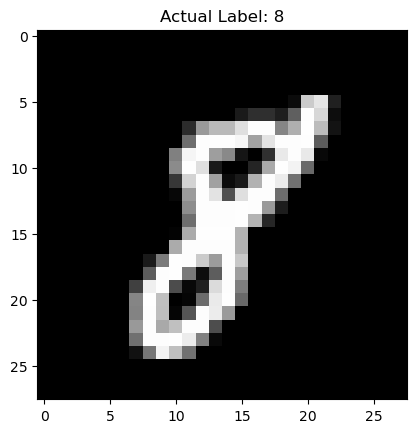

In [3]:
plt.imshow(x_train[17], cmap='gray')
plt.title("Actual Label: " + str(y_train[17]))
plt.show()

***
### Question 2:
##### Display several images from the training set, and the corresponding labels

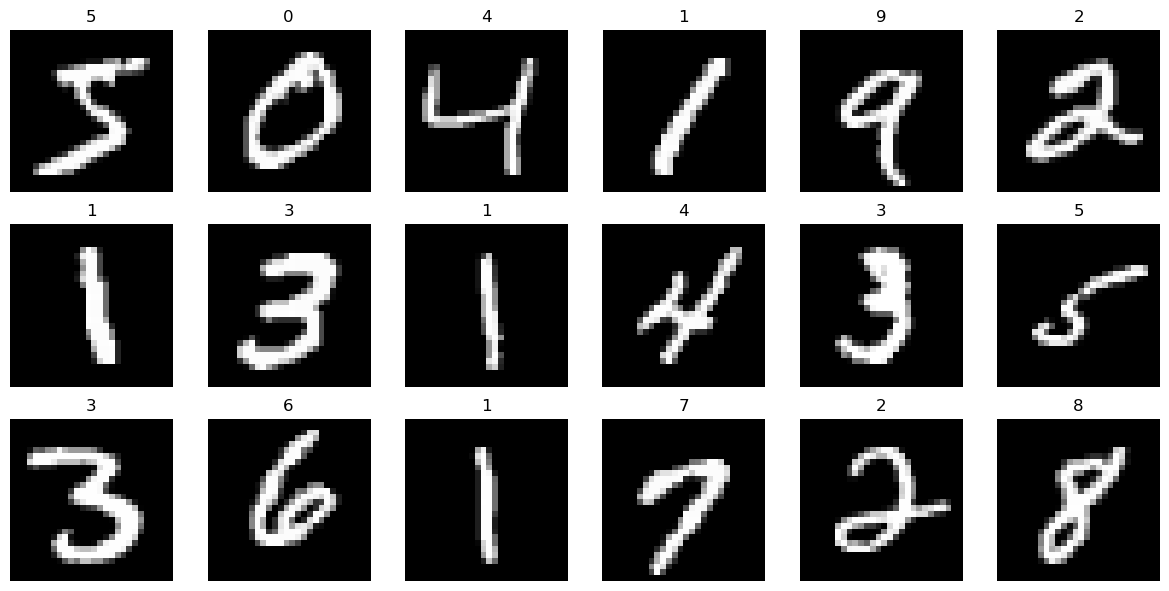

In [4]:
n_row = 3
n_col = 6

fig, axes = plt.subplots(n_row, n_col, figsize=(12, 6))
axes = axes.ravel()

for i in range(n_row * n_col):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(y_train[i]))

plt.tight_layout()
plt.show()

***
### Question 3:
##### a) Write a nearest neighbor classifier function

In [5]:
def nearest_neighbor_classifier(test_image):
    """
    Predicts the label of a test image by finding the ‘closest’ (in terms of L2 distance)
    training image and using its label. This function only considers the first 2000 images
    in the training set.

    :param test_image: MNIST test image
    :type test_image: numpy.ndarray

    :return: label of closest training image
    :rtype: int
    """

    min_dist, min_idx = np.linalg.norm(test_image - x_train[0]), 0
    misclass_idxs = []
    for idx,train_image in enumerate(x_train[:2000]):
        dist = np.linalg.norm(test_image - train_image)
        if dist < min_dist:
            min_dist = dist
            min_idx = idx
    return y_train[min_idx], min_idx

##### b) Use the function to predict the class of the first image in the test dataset. What is the predicted class? Is it correct? What is the misclassification loss? What is the squared error loss?
<span style='color:darkblue'>The predicted class is 7 which is correct. The misclassification loss and squared error loss are both 0.</span>

In [6]:
idx = 0
print(f"Predicted Label: {nearest_neighbor_classifier(x_test[idx])[0]}\nTrue Label: {y_test[idx]}")

Predicted Label: 7
True Label: 7


##### c) Write a for loop to predict the classes of the first 1,000 images in the test set. What is empirical risk of the nearest neighbor classifier when using the misclassification (0/1) loss? What is the empirical risk when using the squared error loss function?

In [7]:
tot_misclassified = 0
tot_sqr_error = np.int8(0)
misclass_idxs, misclass_pred_idxs = [], []
n = 1000

for idx, test_image in enumerate(x_test[:n]):
    pred_label, pred_idx = nearest_neighbor_classifier(test_image)
    pred_label = np.int8(pred_label)
    true_label = np.int8(y_test[idx])
    if pred_label != true_label:
        tot_misclassified += 1
        tot_sqr_error += (pred_label - true_label)**2
        misclass_idxs += [idx]
        misclass_pred_idxs += [pred_idx]

print(f"Misclassification Loss: {tot_misclassified/n}\nSquared Error Loss: {tot_sqr_error/n}")

Misclassification Loss: 0.372
Squared Error Loss: 6.803


##### d) Display some of the images that were classified incorrectly alongside their nearest neighbor, and comment on why the classifier may have made a mistake.
<span style='color:darkblue'>There appear to be two categories of misclassified digits:</span><br>
<span style='color:darkblue'>(1) digits that are written in a unique way and are matched with digits with a thick outline (images 0,2,3,4,5)</span><br>
<span style='color:darkblue'>(2) digits that appear very similar to a different handwritten digit (image 4)</span>

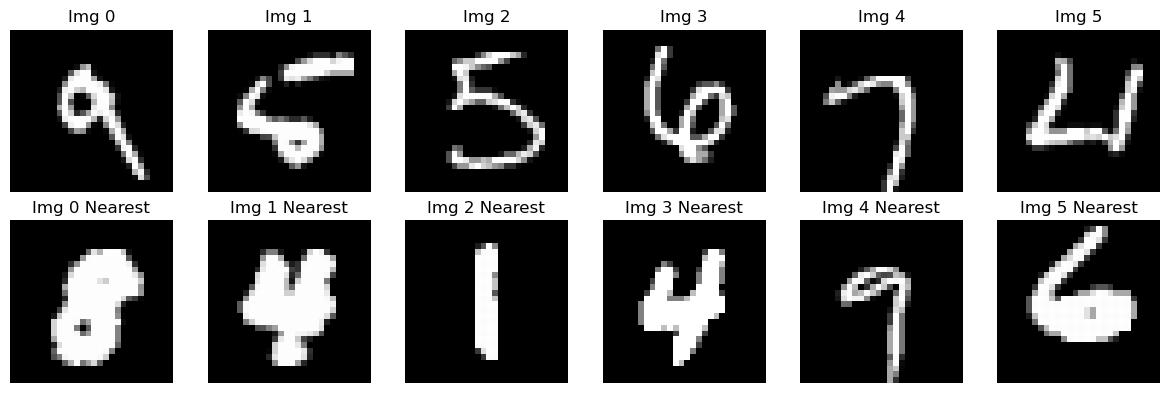

In [8]:
n_row = 2
n_col = 6

fig, axes = plt.subplots(n_row, n_col, figsize=(12, 4))
axes = axes.ravel()

for i,(misclass_idx,misclass_pred_idx) in enumerate(zip(misclass_idxs[:6], misclass_pred_idxs[:6])):
    axes[i].imshow(x_test[misclass_idx], cmap='gray')
    axes[i].set_title('Img ' + str(i))
    axes[i].axis('off')
    axes[i+6].imshow(x_train[misclass_pred_idx], cmap='gray')
    axes[i+6].set_title('Img ' + str(i) + ' Nearest')
    axes[i+6].axis('off')

plt.tight_layout()
plt.show()

***
### Question 4:
##### a) Implement a KNN classifier with k=10

In [9]:
# Code Citation for "_most_frequent" function: 
# https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

class KNNClassifier():

    def __init__(self, k=10, n_train_samples=2000):
        self.distance_index_list = []
        self.k = k
        self.max_dist = None
        self.n_train_samples = n_train_samples

    def _add_distance_label_pair(self, distance, label):
        self.distance_index_list.pop()
        self.distance_index_list.append((distance, label))
        self.distance_index_list.sort()
        self.max_dist = self.distance_index_list[-1][0]

    def _most_frequent(self, List):
        return max(set(List), key = List.count)
        
    def predict(self, test_image):
        for i in range(self.k):
            dist = np.linalg.norm(test_image - x_train[i])
            self.distance_index_list.append((dist, y_train[i]))
        self.max_dist = self.distance_index_list[-1][0]
        for idx,train_image in enumerate(x_train[self.k:self.n_train_samples]):
            dist = np.linalg.norm(test_image - train_image)
            if dist < self.max_dist:
                self._add_distance_label_pair(dist, y_train[self.k+idx])
        indices = [idx for _, idx in self.distance_index_list]
        return self._most_frequent(indices)

In [10]:
tot_misclassified = 0
tot_sqr_error = np.int8(0)
n = 1000

for idx, test_image in tqdm(enumerate(x_test[:n]), total=n):
    clf = KNNClassifier(n_train_samples=2000)
    pred_label = clf.predict(test_image)
    pred_label = np.int8(pred_label)
    true_label = np.int8(y_test[idx])
    if pred_label != true_label:
        tot_misclassified += 1
        tot_sqr_error += (pred_label - true_label)**2

print(f"Misclassification Loss: {tot_misclassified/n}\nSquared Error Loss: {tot_sqr_error/n}")

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 106.34it/s]

Misclassification Loss: 0.35
Squared Error Loss: 6.253
